In [15]:
#!/usr/bin/env python
# coding: utf-8

from imageio.core.request import URI_FILENAME
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from scipy.interpolate import griddata
import pyvista as pv
# from ipyvtklink.viewer import ViewInteractiveWidget

import seaborn as sns

In [16]:
# # COMFORT MISMATCH PLOTS
# 

print('VELOCITY DIFFERENCE') 
print(' ')

U10 = 4.97 #velocity inflow 10 m height [m/s]
kappa =0.41
z0 = 0.2 # roughness length [m]
ustar = U10*kappa/(np.log((10+z0)/z0))     # shouldn not be changed!!
Uph = ustar/kappa*np.log((1.75+z0)/z0)     # shouldn not be changed!!
print ("Uph = ", Uph)

VELOCITY DIFFERENCE
 
Uph =  2.878565700446979


In [17]:
# LADlist = ['02','06', '10','14','16','18','22']
# LADname = ['LAD0.2','LAD0.6', 'LAD1.0','LAD1.4','LAD1.6','LAD1.8','LAD2.2']
LADlist = ['02','06', '10','14','18','22']
LADname = ['LAD0.2','LAD0.6', 'LAD1.0','LAD1.4','LAD1.8','LAD2.2']
d = {}
totalMeshDict = {}

## bounding box streetcanyon buildings (-90 -9 0) (90 45 18)###---------need to be changed---------##
x_min = -90
y_min = -9
z_min = 0
x_max = 90
y_max = 45
z_max = 18

# bounds of clipping box specified as [xMin,xMax, yMin,yMax, zMin,zMax] of the 2 outer vertices:
# bounds2 = [x_min-30,x_max+130, y_min-30,y_max+30, 18, 18]  ###---------need to be changed---------##
# bounds2 = [x_min+3.8,x_max, y_min,y_max, 18, 18] 
bounds2 = [x_min,x_max, y_min,y_max, 6, 6]

# _______________________________________________________________________________
sargs = dict(
    color='k',
    font_family='courier',
    title_font_size=15,
    label_font_size=10,
    n_labels=6,
    fmt="%.1f",
    height=0.05, 
    width=0.7, 
    vertical=False, 
    position_x=0.16, 
    position_y=0.02,
    n_colors=20,
    title='Relative Velocity Magnitude difference [%]'
    )

LAD =  02
min =  -21.613705
max =  30.623356
mean =  8.437196
std =  6.4015827


/Users/runnanfu/opt/anaconda3/envs/my_env/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'


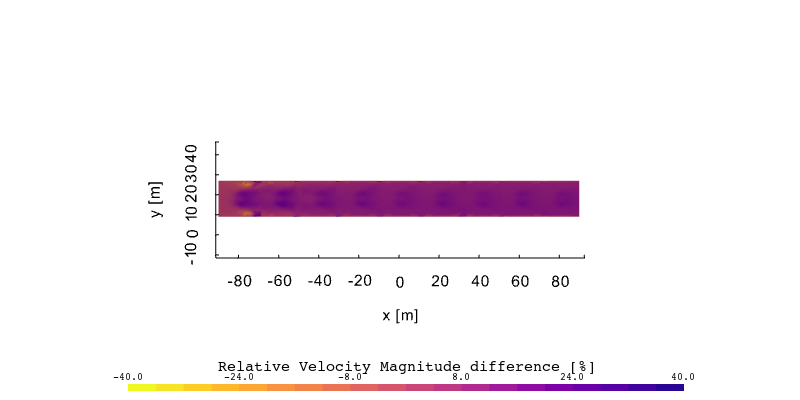

LAD =  06
min =  -19.558863
max =  38.545532
mean =  13.61187
std =  10.16558


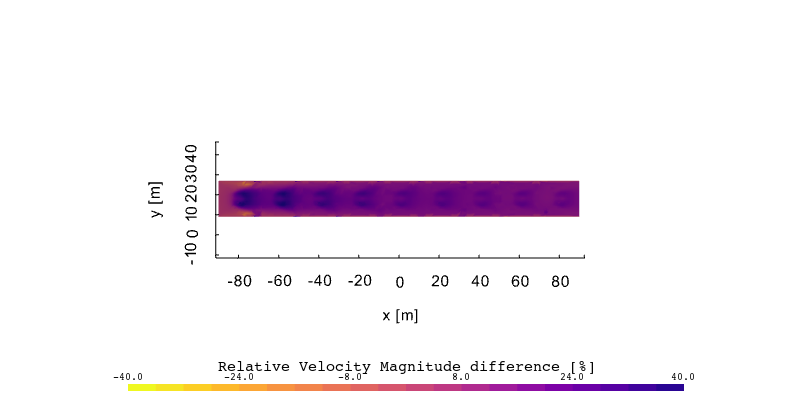

LAD =  10
min =  -18.851284
max =  49.32163
mean =  15.888258
std =  12.248093


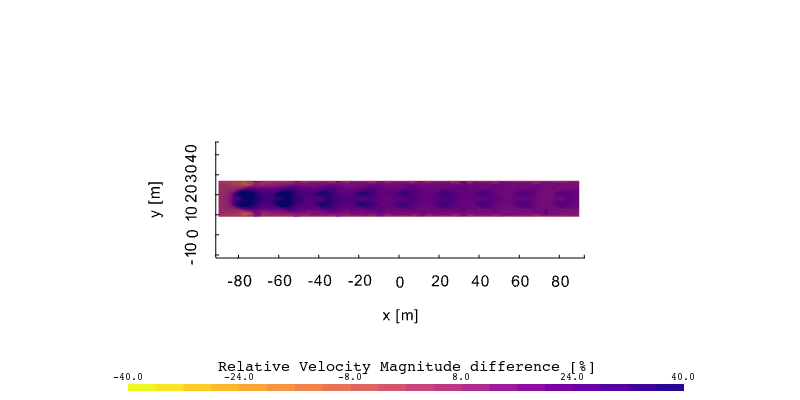

LAD =  14
min =  -17.965582
max =  57.928402
mean =  17.279839
std =  13.733994


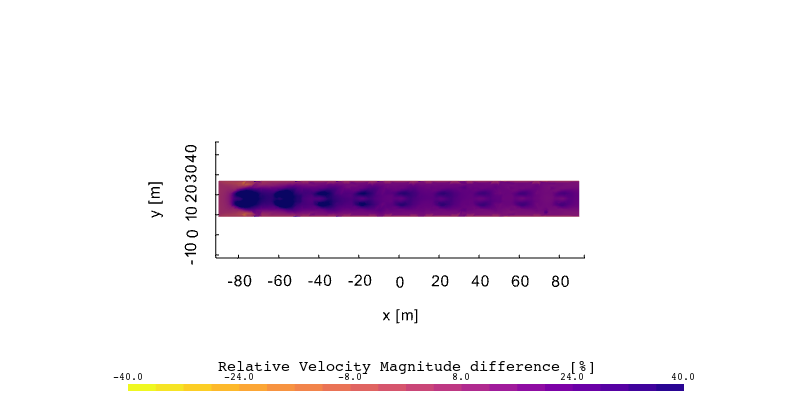

LAD =  18
min =  -17.062529
max =  64.59378
mean =  18.198961
std =  14.791183


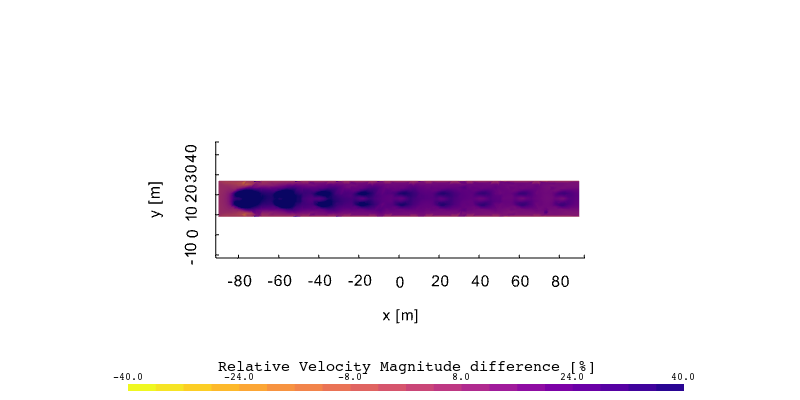

LAD =  22
min =  -16.265177
max =  70.05808
mean =  18.78378
std =  15.550813


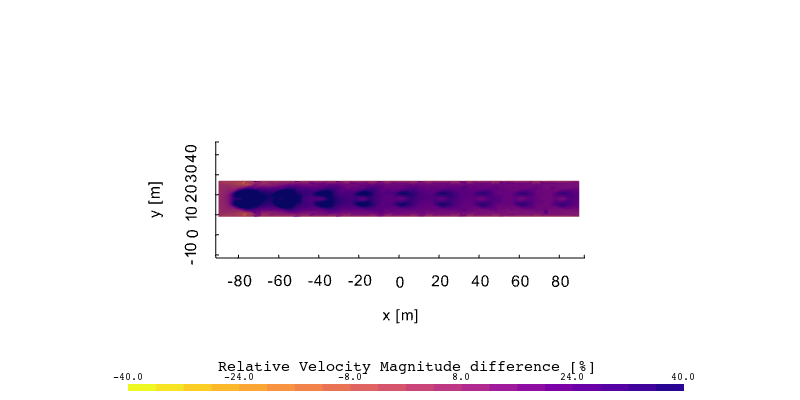

In [18]:
# _______________________________________________________________________________

for i in range(len(LADlist)):
    # sampled results from postProcessing > surfaces ##broadleaf conifer ##U_pedestrianH U_z6Normal U_z9Normal U_z12Normal U_z15Normal U_z18Normal
    surface_U1 = pv.read('../LoD3/LAD' + LADlist[i] + '/broadleaf/postProcessing/surfaces/1152/U_z6Normal.vtk') ###---------need to be changed---------##
    surface_U2 = pv.read('../LoD2/LAD' + LADlist[i] + '/broadleaf/postProcessing/surfaces/1152/U_z6Normal.vtk')
    # interpolation between the meshes for U:
    U1_mesh1 = pv.PolyData(surface_U1)
    U2_mesh2 = pv.PolyData(surface_U2)
    # U1_mesh2 = U2_mesh2.sample(U1_mesh1)
        
    #sharpness=2, radius=1.0
    U1_mesh2 = U2_mesh2.interpolate(U1_mesh1, sharpness=2, radius=0.5, strategy='closest_point', null_value=0,pass_cell_arrays=False, pass_point_data=False)
    
    clippedU1 = U1_mesh2.clip_box(bounds2, invert=False) # note: invert clip if you want to remove the box and keep everything around it 
    clippedU2 = U2_mesh2.clip_box(bounds2, invert=False)

    # take the norm of the velocity vector (magnitude):
    clippedU1['magnitude'] = np.linalg.norm(clippedU1['U'], axis=1)
    clippedU2['magnitude'] = np.linalg.norm(clippedU2['U'], axis=1)

    # compute the difference
    U_effect = ((clippedU2.point_data['magnitude'] - clippedU1.point_data['magnitude'])/Uph)*100

    data_final_U = clippedU2
    data_final_U.point_data['magnitude'] = U_effect 
    deltaU_scalars = data_final_U.point_data['magnitude']
    
    #modify d and totalMeshDict
    d[LADname[i]]=deltaU_scalars
    totalMeshDict[LADname[i]] = data_final_U
    
    # plotter set-up (create 2 subplots): bad pedestrian vs. good thermal comfort 
    plotter = pv.Plotter(shape=(1, 1),window_size=[800, 400], border=False)
    plotter.set_background("w")
    pv.set_plot_theme("document")

    # -------------
    print("LAD = ", LADlist[i])
    print("min = ", deltaU_scalars.min())
    print("max = ", deltaU_scalars.max())
    print("mean = ",deltaU_scalars.mean())
    print("std = ", np.std(deltaU_scalars))

    #stitle='Relative Velocity Magnitude difference [%]',
    plotter.add_mesh(data_final_U, scalars=deltaU_scalars, clim=[-40,40],scalar_bar_args=sargs, cmap="plasma_r") 

    plotter.show_bounds(xlabel='x [m]', ylabel='y [m]', color='black')
    #plotter.add_text('VELOCITY LoD1', font='courier', font_size=9, position='upper_edge')
    plotter.view_xy()   # plot the xy-plane
    plotter.enable_zoom_style()   # enable to zoom in the image

    # show and save the created subplots:  ###---------need to be changed---------##
    # plotter.show(screenshot='[-10-10]/conifer_LoD2-3_LAD22_U18')
    plotter.show()

         LAD0.2     LAD0.6     LAD1.0     LAD1.4     LAD1.8     LAD2.2
0      2.105076   5.185620   6.837674   7.912053   8.680077   9.245675
1      1.707165   4.075361   5.333265   6.121134   6.663028   7.045218
2      1.767131   4.077316   5.297153   6.051246   6.567265   6.933321
3      2.172827   5.150237   6.742839   7.773618   8.506971   9.054978
4      2.980110   7.369529   9.833106  11.528991  12.814906  13.834869
...         ...        ...        ...        ...        ...        ...
3700  14.199450  20.764330  23.944618  26.336569  28.157097  29.530216
3701  11.946837  15.709251  17.895115  19.548788  20.658419  21.228296
3702  12.051504  15.874463  18.071625  19.741770  20.886492  21.489126
3703  12.184258  15.942915  18.065205  19.670355  20.749916  21.326422
3704  11.911678  15.799453  17.996983  19.609478  20.729382  21.329521

[3705 rows x 6 columns]


<AxesSubplot:>

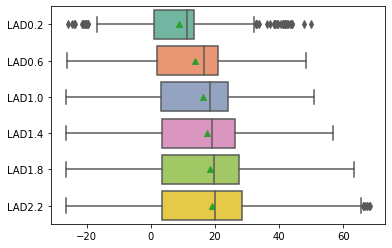

In [5]:
df = pd.DataFrame(data=d)
print(df)

sns.boxplot(data = df,showmeans=True,orient="h",palette="Set2")


In [6]:
df_t = df.T
df_t_02 = df_t.loc[["LAD0.2"]].T.rename(columns={"LAD0.2": "values"})
df_t_02["LAD"] = 0.2
df_t_02 = df_t_02[["LAD", "values"]]

df_t_06 = df_t.loc[["LAD0.6"]].T.rename(columns={"LAD0.6": "values"})
df_t_06["LAD"] = 0.6
df_t_06 = df_t_06[["LAD", "values"]]

df_t_10 = df_t.loc[["LAD1.0"]].T.rename(columns={"LAD1.0": "values"})
df_t_10["LAD"] = 1.0
df_t_10 = df_t_10[["LAD", "values"]]

df_t_14 = df_t.loc[["LAD1.4"]].T.rename(columns={"LAD1.4": "values"})
df_t_14["LAD"] = 1.4
df_t_14 = df_t_14[["LAD", "values"]]

df_t_18 = df_t.loc[["LAD1.8"]].T.rename(columns={"LAD1.8": "values"})
df_t_18["LAD"] = 1.8
df_t_18 = df_t_18[["LAD", "values"]]

df_t_22 = df_t.loc[["LAD2.2"]].T.rename(columns={"LAD2.2": "values"})
df_t_22["LAD"] = 2.2
df_t_22 = df_t_22[["LAD", "values"]]

frames = [df_t_02,df_t_06,df_t_10,df_t_14,df_t_18,df_t_22]

result = pd.concat(frames)
result = result.reset_index()

<AxesSubplot:xlabel='LAD', ylabel='values'>

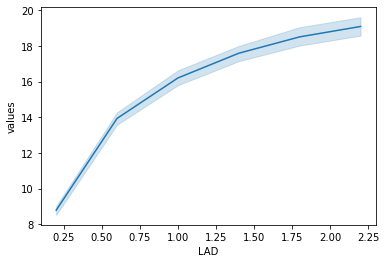

In [7]:
sns.lineplot(data=result, x="LAD", y="values")

In [8]:
dfMeans = df.mean()
dfSTD = df.std()
print(dfMeans.tail())
dfMeansAndSTD= {"LAD values" : np.array(dfMeans.index), "Mean": dfMeans.values, "Standard Deviation": dfSTD.values}
dfMeansAndSTD = pd.DataFrame(data=dfMeansAndSTD).set_index('LAD values')
dfMeansAndSTD

LAD0.6    13.938745
LAD1.0    16.210531
LAD1.4    17.599718
LAD1.8    18.517092
LAD2.2    19.100906
dtype: float32


,Mean,Standard Deviation
LAD values,,
LAD0.2,8.786058,7.739856
LAD0.6,13.938745,10.878652
LAD1.0,16.210531,12.772254
LAD1.4,17.599718,14.149568
LAD1.8,18.517092,15.136119
LAD2.2,19.100906,15.844784


<AxesSubplot:xlabel='LAD values'>

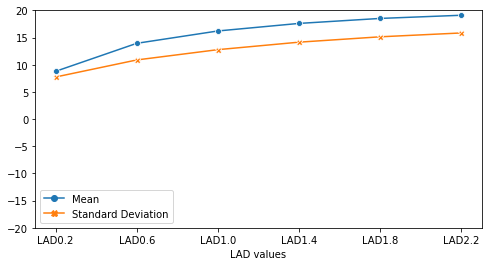

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.set(ylim=(-20, 20))
sns.lineplot(data=dfMeansAndSTD,markers=True, dashes=False)

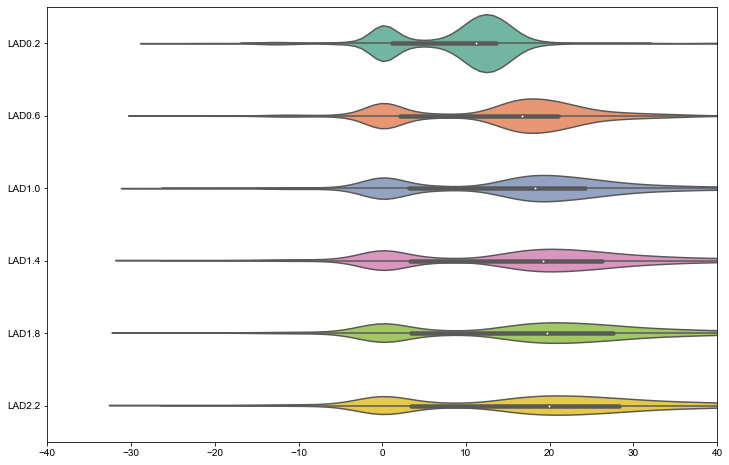

In [10]:
# sns.set(rc = {'figure.figsize':(10,8)})
# f = plt.figure(figsize=(6, 6))
fig, ax = plt.subplots(figsize=(12, 8))
ax.set(xlim=(-40, 40))
sns.set_style("whitegrid")
vio_plot = sns.violinplot(data = df,showmeans=True,orient="h",palette="Set2", aspect=1.5,height=8,ax=ax)

# Plot over line

In [11]:
dABline = {}
dCDline = {}
dEFline = {}
for i in totalMeshDict:
    mesh = totalMeshDict[i]
    # print(mesh.bounds)
    # a = [13.5, mesh.bounds[2], mesh.bounds[5]]
    # b = [13.5, mesh.bounds[3], mesh.bounds[5]]
    # c = [18, mesh.bounds[2], mesh.bounds[5]]
    # d = [18, mesh.bounds[3], mesh.bounds[5]]
    # e = [22.5, mesh.bounds[2], mesh.bounds[5]]
    # f = [22.5, mesh.bounds[3], mesh.bounds[5]]
    a = [ mesh.bounds[0], 13.5, mesh.bounds[5]]
    b = [mesh.bounds[1], 13.5, mesh.bounds[5]]
    c = [mesh.bounds[0], 18, mesh.bounds[5]]
    d = [mesh.bounds[1], 18,  mesh.bounds[5]]
    e = [mesh.bounds[0], 22.5, mesh.bounds[5]]
    f = [mesh.bounds[1],22.5,  mesh.bounds[5]]
    
#     line1 = pv.Line(a, b)
#     line2 = pv.Line(c, d)
#     line3 = pv.Line(e, f)
    
#     p = pv.Plotter(shape=(1, 3),window_size=[1000, 500], border=False)
#     p.subplot(0, 1)
#     p.add_mesh(mesh)
#     p.add_mesh(line3, color="white", line_width=2)
#     p.add_point_labels([c, d], ["A", "B"], font_size=18, point_color="red", text_color="red")
#     p.show_bounds(xlabel='y [m]', ylabel='x [m]', color='black')
#     #plotter.add_text('VELOCITY LoD1', font='courier', font_size=9, position='upper_edge')
#     p.view_xy()   # plot the xy-plane
#     p.enable_zoom_style() 
#     p.show()
    
#     mesh.plot_over_line(
#     a,
#     b,
#     resolution=1000,
#     title="Velocity Magnitude over line AB",
#     ylabel="Velocity Magnitude",
#     figsize=(10, 5)
# )
    sampleAB = mesh.sample_over_line(a, b,resolution=1000)
    sampleABscalar = sampleAB.point_data['magnitude']
    dABline[i] = sampleABscalar
    
    sampleCD = mesh.sample_over_line(c, d,resolution=1000)
    sampleCDscalar = sampleCD.point_data['magnitude']
    dCDline[i] = sampleCDscalar 
    
    sampleEF = mesh.sample_over_line(e, f,resolution=1000)
    sampleEFscalar = sampleEF.point_data['magnitude']
    dEFline[i] = sampleEFscalar  
    

In [12]:
### plot lines
mesh = totalMeshDict['LAD0.2']
# print(mesh.bounds)
# a = [13.5, mesh.bounds[2], mesh.bounds[5]]
# b = [13.5, mesh.bounds[3], mesh.bounds[5]]
# c = [18, mesh.bounds[2], mesh.bounds[5]]
# d = [18, mesh.bounds[3], mesh.bounds[5]]
# e = [22.5, mesh.bounds[2], mesh.bounds[5]]
# f = [22.5, mesh.bounds[3], mesh.bounds[5]]

a = [ mesh.bounds[0], 13.5, mesh.bounds[5]]
b = [mesh.bounds[1], 13.5, mesh.bounds[5]]
c = [mesh.bounds[0], 18, mesh.bounds[5]]
d = [mesh.bounds[1], 18,  mesh.bounds[5]]
e = [mesh.bounds[0], 22.5, mesh.bounds[5]]
f = [mesh.bounds[1],22.5,  mesh.bounds[5]]

line1 = pv.Line(a, b)
line2 = pv.Line(c, d)
line3 = pv.Line(e, f)

# p = pv.Plotter(shape=(1, 1),window_size=[500, 300], border=False)
# p.add_mesh(mesh)
# p.add_mesh(line1, color="red", line_width=2)
# # p.add_mesh(line2, color="red", line_width=2)
# # p.add_mesh(line3, color="red", line_width=2)
# p.add_point_labels([a,b], ["A", "B"], font_size=18, point_color="red", text_color="red",always_visible=True)
# # p.show_bounds(xlabel='y [m]', ylabel='x [m]', color='black')
# # #plotter.add_text('VELOCITY LoD1', font='courier', font_size=9, position='upper_edge')
# p.view_xy()   # plot the xy-plane
# p.enable_zoom_style() 
# p.show()

<AxesSubplot:title={'center':'Plot Over Line E-F'}>

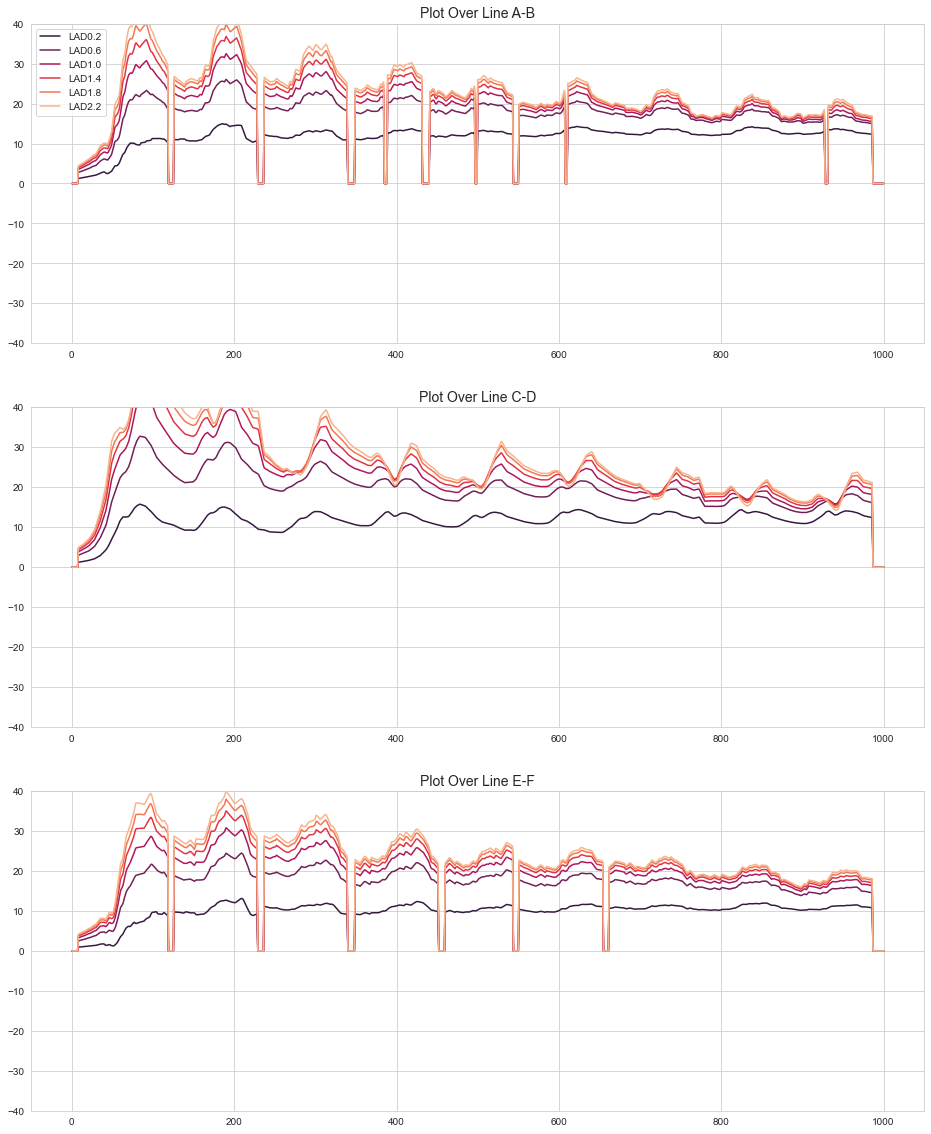

In [13]:
fig, ax = plt.subplots(3,1,figsize=(16, 20))

dfABline = pd.DataFrame(data=dABline)
ax[0].set_title('Plot Over Line A-B', fontsize = 14)
ax[0].set(ylim=(-40, 40))
sns.lineplot(data=dABline,markers=False, dashes=False,palette="rocket",ax = ax[0])

    
dfCDline = pd.DataFrame(data=dCDline)
ax[1].set_title('Plot Over Line C-D', fontsize = 14)
ax[1].set(ylim=(-40, 40))
sns.lineplot(data=dCDline,markers=False, dashes=False,palette="rocket",ax = ax[1],legend = False)

    
dfEFline = pd.DataFrame(data=dEFline)
ax[2].set_title('Plot Over Line E-F', fontsize = 14)
ax[2].set(ylim=(-40, 40))
sns.lineplot(data=dEFline,markers=False, dashes=False,palette="rocket",ax = ax[2],legend = False)
           
    